In [1]:
import sys
sys.path.append('../')
from Dynamics.SR_functions import Parameters, erf
from parameters import D1_ND, Parameters
from twobox import TwoBox
import numpy as np
import matplotlib.pyplot as plt

In [3]:
wavelength      = 1.5 / D1_ND(1.2/100)
grating_pitch   = 1.8 / wavelength
grating_depth   = 0.5 / wavelength
box1_width      = 0.15 * grating_pitch
box2_width      = 0.35 * grating_pitch
box_centre_dist = 0.60 * grating_pitch
box1_eps        = 3.5**2 
box2_eps        = 3.5**2
gaussian_width  = 5 * 10 #2.18
substrate_depth = 0.5 / wavelength
substrate_eps   = 1.45**2

wavelength      = 1.
angle           = 0.
Nx              = 100
numG            = 25
Qabs            = np.inf

grating = TwoBox(grating_pitch, grating_depth, box1_width, box2_width, box_centre_dist, box1_eps, box2_eps, 
                 gaussian_width, substrate_depth, substrate_eps,
                 wavelength, angle, Nx, numG, Qabs)

In [4]:
I = 10e9; m=1/1000; c=299792458
grating.wavelength = 1 / D1_ND(5.75/100)
print(grating.Eigs(I,m,c,"grad",False,False))

(array([-2.55523875e-04, -2.55523875e-04, -9.84831983e-05, -9.84831983e-05]), array([  19.93155565,  -19.93155565,  184.7265072 , -184.7265072 ]))


In [41]:
## Start at width w= 2.18
L = 10

k_lambda = 200
final_speed = 5.75/100
lambda_array = np.linspace(1, 1/D1_ND(final_speed),k_lambda)

k_width = 1000
# k_mid = 2.715135135135135
# k_mid = 2.717835132429727
# k_mid = 2.7180353326299276
# k_mid = 2.7180153126099076
# k_mid     = 2.7180083056029005
# k_mid     = 2.718006804101399
# k_mid       = 2.7180098071044023
# k_mid       = 2.7180078051024004
k_mid       = 2.7180049942915896
k_upper = 2.7180049942915896 + 4e-8
k_lower = 2.7180049942915896 - 4e-8
# k_sep       = (k_upper -k_lower)/k_width
# k_upper = k_mid + k_sep
# k_lower = k_mid - k_sep
width_array = np.linspace(k_lower, k_upper, k_width)

# Jacobian term matrices
ky_y_array=       np.zeros((k_lambda, k_width))
ky_phi_array=     np.zeros((k_lambda, k_width))
muy_y_array=      np.zeros((k_lambda, k_width))
muy_phi_array=    np.zeros((k_lambda, k_width))
kphi_y_array=     np.zeros((k_lambda, k_width))
kphi_phi_array=   np.zeros((k_lambda, k_width))
muphi_y_array=    np.zeros((k_lambda, k_width))
muphi_phi_array=  np.zeros((k_lambda, k_width))

FoM_array = np.zeros(k_width)
FoM2_array = np.zeros(k_width)
FoM3_array = np.zeros(k_width)

## Get all the data
for i in range(k_lambda):
    lam = lambda_array[i]

    # Retrieve efficiency factors
    grating.wavelength = lam
    Q1R, Q2R, dQ1ddeltaR, dQ2ddeltaR, dQ1dlambdaR, dQ2dlambdaR = grating.return_Qs_auto(return_Q=True)

    ## Convert velocity dependence to wavelength dependence
    D = 1/lam 
    g = (np.power(lam,2) + 1)/(2*lam) 

    ## Symmetry
    Q1L = Q1R;   Q2L = -Q2R;   
    dQ1ddeltaL  = -dQ1ddeltaR;    dQ2ddeltaL  = dQ2ddeltaR
    dQ1dlambdaL = dQ1dlambdaR;    dQ2dlambdaL = -dQ2dlambdaR

    ## Calculate width-independent terms
    # y acceleration
    ky_y= -     D**2 * (I/(m*c)) *  ( Q2R - Q2L ) 
    ky_phi= -   D**2 * (I/(m*c)) * ( dQ2ddeltaR + dQ2ddeltaL )
    muy_y= -    D**2 * (I/(m*c)) * (1/c) * ( (D+1)/(D*(g+1)) ) * ( Q1R + Q1L  + dQ2ddeltaR + dQ2ddeltaL ) 
    muy_phi=    D**2 * (I/(m*c)) * (1/c) * ( 2*( Q2R - Q2L ) - lam*( dQ2dlambdaR - dQ2dlambdaL ) )

    # phi acceleration
    kphi_y=     D**2 * (12*I/( m*c*L**2)) * ( Q1R + Q1L )
    kphi_phi=   D**2 * (12*I/( m*c*L**2)) * ( dQ1ddeltaR - dQ1ddeltaL - ( Q2R - Q2L ) )
    muphi_y=    D**2 * (12*I/( m*c*L**2)) * (1/c) * ( (D+1)/(D*(g+1)) ) * ( dQ1ddeltaR - dQ1ddeltaL - ( Q2R - Q2L ) )
    muphi_phi= -D**2 * (12*I/( m*c*L**2)) * (1/c) * ( 2*( Q1R + Q1L ) - lam*( dQ1dlambdaR + dQ1dlambdaL ) )

    ## Go across widths
    for j in range(k_width):
        w_bar = width_array[j]
        w = w_bar * L
        ## Jacobian terms
        # y acceleration
        ky_y_w = ky_y *                      ( 1 - np.exp(-1/(2*w_bar**2) ) )
        ky_phi_w = ky_phi *                  (w/2) * np.sqrt( np.pi/2 ) * erf( 1/(w_bar*np.sqrt(2)) )
        muy_y_w = muy_y *                    (w/2) * np.sqrt( np.pi/2 ) * erf( 1/(w_bar*np.sqrt(2)) )
        muy_phi_w = muy_phi *     (w/2)**2 * ( 1 - np.exp( -1/(2*w_bar**2) ))
        # phi acceleration
        kphi_y_w = kphi_y *                  ( (w/2)*np.sqrt( np.pi/2 )  * erf( 1/(w_bar*np.sqrt(2)))  - (L/2)* np.exp( -1/(2*w_bar**2) ) ) 
        kphi_phi_w = kphi_phi *   (w/2)**2 * ( 1 - np.exp( -1/(2*w_bar**2) ))
        muphi_y_w = muphi_y *     (w/2)**2 * ( 1 - np.exp( -1/(2*w_bar**2) ))
        muphi_phi_w = muphi_phi * (w/2)**2 * ( (w/2)*np.sqrt( np.pi/2 )  * erf( 1/(w_bar*np.sqrt(2)))  - (L/2)* np.exp( -1/(2*w_bar**2) ) ) 

        ky_y_array[i,j]=        ky_y_w
        ky_phi_array[i,j]=      ky_phi_w
        muy_y_array[i,j]=       muy_y_w
        muy_phi_array[i,j]=     muy_phi_w
        kphi_y_array[i,j]=      kphi_y_w
        kphi_phi_array[i,j]=    kphi_phi_w
        muphi_y_array[i,j]=     muphi_y_w
        muphi_phi_array[i,j]=   muphi_phi_w

def FoM(i,j):
    ky_y_w      =           ky_y_array[i,j]
    ky_phi_w    =           ky_phi_array[i,j]      
    muy_y_w     =           muy_y_array[i,j]      
    muy_phi_w   =           muy_phi_array[i,j]     
    kphi_y_w    =           kphi_y_array[i,j]      
    kphi_phi_w  =           kphi_phi_array[i,j]
    muphi_y_w   =           muphi_y_array[i,j]    
    muphi_phi_w =           muphi_phi_array[i,j]
    
    J00=ky_y_w;   J01=ky_phi_w;     J02=muy_y_w;    J03=muy_phi_w
    J10=kphi_y_w; J11=kphi_phi_w;   J12=muphi_y_w;  J13=muphi_phi_w
    J=np.array([[0,0,1,0],[0,0,0,1],[J00,J01,J02,J03],[J10,J11,J12,J13]])

    # Find the real part of eigenvalues    
    EIGVALVEC   = np.linalg.eig(J)
    eig         = EIGVALVEC[0]
    eigReal     = np.real(eig)
    eigImag     = np.imag(eig)

    def unique_filled(x, filled_value):
            """
            ## Inputs
            x: 4-d array
            filled_value: Float to fill remaining

            ## Outputs
            Unique contents of x, with remaining items filled by filled_value
            """
            # Sort to ensure differentiability
            sorted_x = np.sort(x.flatten())
            unique_values = sorted_x[np.concatenate(([True], np.diff(sorted_x) != 0))]

            # Append filled_value as needed
            k = len(unique_values)
            for i in range(4-k):
                unique_values=np.append(unique_values,filled_value)

            return unique_values
    
    unique_real = unique_filled(eigReal,1)
    unique_imag = unique_filled(eigImag,1)

    FoM1 = np.prod(unique_real)
    FoM2 = np.prod(unique_imag)
    FoM3 = FoM1 * FoM2

    return FoM1, FoM2, FoM3
     
## Go across each row and find the figure of merit
for j in range(k_width):
    FoM_lambda = np.zeros(k_lambda)
    FoM2_lambda = np.zeros(k_lambda)
    FoM3_lambda = np.zeros(k_lambda)
    for i in range(k_lambda):
        FoM_lambda[i], FoM2_lambda[i], FoM3_lambda[i] = FoM(i,j)
    FoM_array[j] = np.trapezoid(FoM_lambda,lambda_array) / (lambda_array[-1]-lambda_array[0])
    FoM2_array[j] = np.trapezoid(FoM2_lambda,lambda_array) / (lambda_array[-1]-lambda_array[0])
    FoM3_array[j] = np.trapezoid(FoM3_lambda,lambda_array) / (lambda_array[-1]-lambda_array[0])



In [6]:
### PLOTTING ### 
from matplotlib.ticker import Locator
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath, physics}')

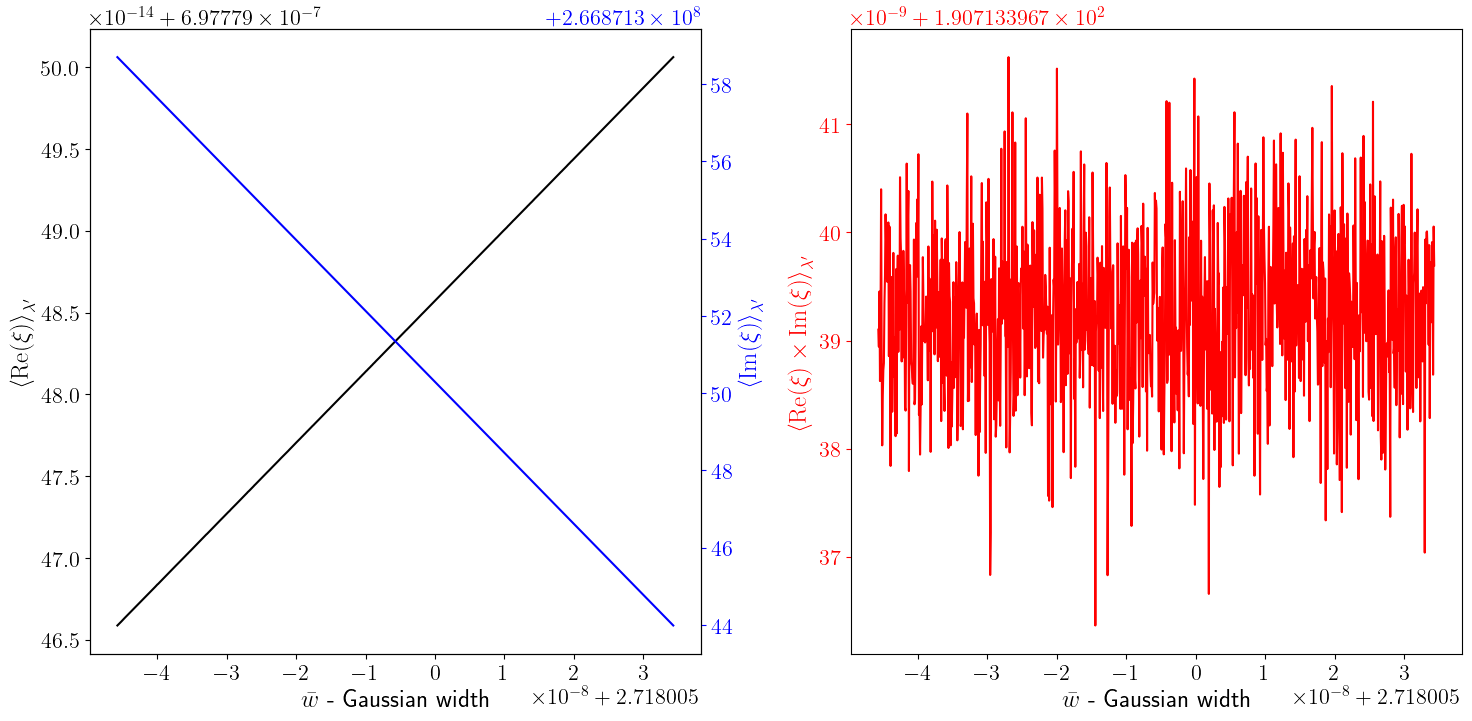

In [42]:
fig, (ax,ax2) = plt.subplots(1,2)
color1 = 'black'
color2 = 'blue'
color3 = 'red'
color4 = 'green'

ax.plot(width_array,FoM_array,color=color1)
ax.set_ylabel(r"$\expval{\Re(\xi)}_{\lambda'}$", color=color1)
ax.tick_params(axis="y",labelcolor=color1,color=color1)

ax1=ax.twinx()
ax1.plot(width_array,FoM2_array,color=color2)
ax1.set_ylabel(r"$\expval{\Im(\xi)}_{\lambda'}$", color=color2)
ax1.tick_params(axis="y", labelcolor=color2, color=color2)

ax.set(xlabel=r"$\bar{w}$ - Gaussian width")

ax2.plot(width_array,FoM3_array, color=color3)
ax2.set_ylabel(r"$\expval{\Re(\xi)\times \Im(\xi)}_{\lambda'}$", color=color3)
ax2.tick_params(axis="y", labelcolor=color3, color=color3)

# ax3=ax2.twinx()
# ax3.plot(width_array,FoM_array*FoM2_array,color=color4)
# ax3.set_ylabel(r"$\expval{\Re(\xi)}_{\lambda'}\times \expval{\Re(\xi)\Im(\xi)}_{\lambda'}$", color=color4)
# ax3.tick_params(axis="y", labelcolor=color4, color=color4)

ax2.set(xlabel=r"$\bar{w}$ - Gaussian width")

fig.tight_layout()

In [36]:
print(width_array[FoM3_array==max(FoM3_array)][0])

2.7180049942915896


In [30]:
k_sep

3.999999999999559e-06

In [ ]:
# 2.715135135135135
# 2.717835132429727
# 2.7180353326299276
# 2.7180153126099076
# 2.7180083056029005
# 2.718006804101399
# 2.7180098071044023
# 2.7180078051024004
# 2.7180049942915896